## Projeto Previsão de Churn com Telco Customer Churn

In [19]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

#Carregando os dados
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
#print(df.head())
print(df.shape)

(7043, 21)


### Entendendo os dados

In [20]:
#Valores nulos
print(df.isnull().sum())
#Removendo a coluna id
df = df.drop(['customerID'], axis=1)

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


### Analisando a variável alvo e os tipos de variáveis

In [21]:
#Frequencia do Churn
print(df['Churn'].value_counts(normalize=True))
# Convertendo o alvo para binario
df['Churn'] = df['Churn'].map({'No':0, 'Yes':1})
#Colunas categoricas e numericas
numeric_col = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_cols = [col for col in df.columns if df[col].dtype == 'object' and col not in numeric_col + ['Churn']]
print(f"\nColunas Categoricas: {cat_cols}\n")
print(f"Colunas Numericas: {numeric_col}")

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

Colunas Categoricas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Colunas Numericas: ['tenure', 'MonthlyCharges', 'TotalCharges']


### Separando alvo e feature

In [22]:
#Corrigindo a coluna TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
#alvo e feature
y = df['Churn']
X = df.drop(['Churn'], axis=1)

### Distribuicao do Churn entre as classes

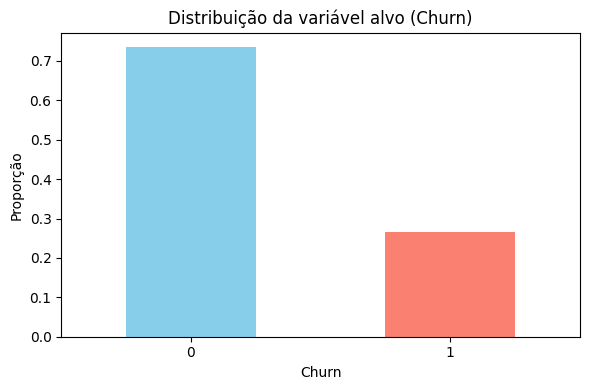

In [23]:
import matplotlib.pyplot as plt
# Distribuição da variável alvo
plt.figure(figsize=(6,4))
df['Churn'].value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Distribuição da variável alvo (Churn)")
plt.ylabel("Proporção")
plt.xlabel("Churn")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [24]:
#Dados de treino e validacao
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [25]:
#Com o StandardScaler, o modelo decide de forma justa qual é mais importante.
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
#juntando os transformadores
preprocessor = ColumnTransformer(
    transformers=[
    ('num', numeric_transformer, numeric_col),
    ('cat', categorical_transformer, cat_cols)
])

In [26]:
#Pipeline
minha_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=0))
    ])
#Treinar o modelo
minha_pipe.fit(X_train, y_train)
#Previsao
predict = minha_pipe.predict(X_val)

### Avaliando o modelo

In [27]:
#Avaliar
print("\n== Classificaco ==\n")
print(classification_report(y_val, predict))


== Classificaco ==

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1041
           1       0.61      0.47      0.53       368

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409



#### Resumo do ```classification_report(y_val, predict)```

- precision → Pessoas que o modelo avisou que iam cancelar, quantas realmente cancelaram.

- recall → Pessoas que realmente cancelaram, quantas o modelo consehuiu avisar.

- f1-score → Desempenho geral equilibrando precisão e recall.

- support → Quantas pessoas realmente estavam em cada grupo/classe (cancelou/não cancelou).


In [28]:
print(confusion_matrix(y_val, predict))
cm = confusion_matrix(y_val, predict)
TN, FN, FP, TP = cm.ravel()
# Gerar a string em formato Markdown
tabela_markdown = f"""
|                  | Previsto = 0 | Previsto = 1 |
|------------------|--------------|--------------|
| Real = 0 (ficou) | {TN} (TN)    | {FP} (FP)    |
| Real = 1 (saiu)  | {FN} (FN)    | {TP} (TP)    |
"""
print(tabela_markdown)

[[931 110]
 [194 174]]

|                  | Previsto = 0 | Previsto = 1 |
|------------------|--------------|--------------|
| Real = 0 (ficou) | 931 (TN)    | 194 (FP)    |
| Real = 1 (saiu)  | 110 (FN)    | 174 (TP)    |



#### Como interpretar:

- TN (True Negative) → 931 clientes ficaram, e o modelo previu “ficou”
- FP (False Positive) → 194 clientes ficaram, mas o modelo disse “saiu”
- FN (False Negative) → 110 clientes saíram, mas o modelo disse “ficou”
- TP (True Positive) → 174 clientes saíram, e o modelo previu “saiu”

In [29]:
print(f"\nROC AUC: {roc_auc_score(y_val, predict):.5f}")


ROC AUC: 0.68358


 #### Explicacao do ROC AUC

O ROC AUC (Receiver Operating Characteristic - Area Under Curve). Ele mede a capacidade do modelo de separar as classes.
Valores típicos:
- 0.5 → modelo aleatório (chutar cara ou coroa).
- 0.7–0.8 → modelo razoável.
- 0.8–0.9 → modelo bom.
- 0.9 ou + → modelo excelente.

OBS: Diferente de precisão/recall isolados, o ROC AUC olha para a performance global do modelo em diferentes limiares de decisão.

### Visualizacao

In [30]:
import numpy as np
#Retornando o modelo
modelo = minha_pipe.named_steps['classifier']
#Retornando o nome das listas resultantes do OneHot Encoder
colunas_cat = list(minha_pipe.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_cols))

total_colunas = numeric_col + colunas_cat

In [31]:
#Importancia
importancia = modelo.feature_importances_
indices = np.argsort(importancia)[::-1] #indices das importancias do maior p/ menor

É quanto cada variável ajudou na redução de impureza, ou seja, quanto ajudou a separar os clientes que saem dos que ficam

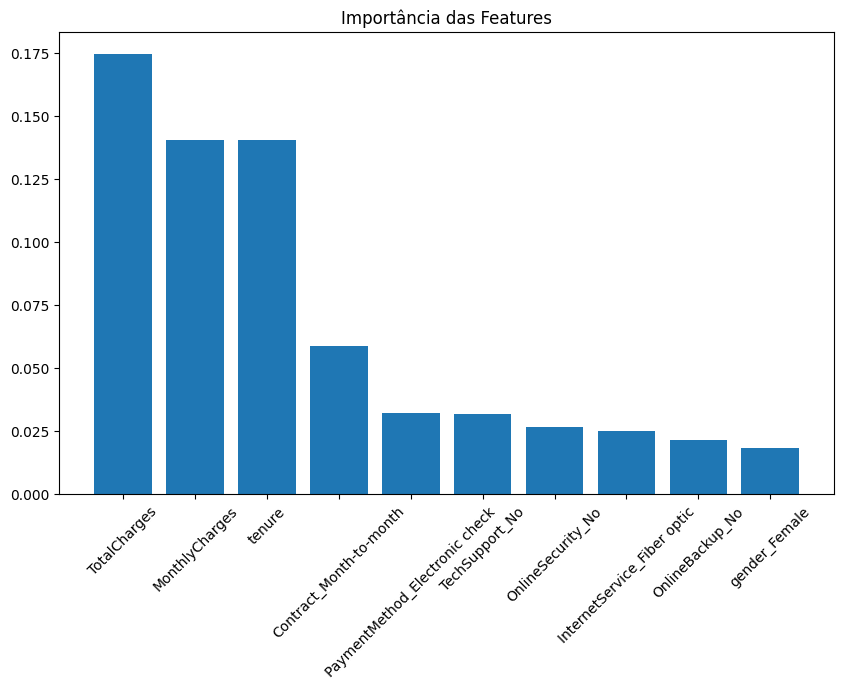

In [32]:
#Plotando
plt.figure(figsize = (10,6))
plt.title("Importância das Features")
plt.bar(range(10), importancia[indices[:10]], align='center')
#substitui os ticks por nomes das features, rotacionados 45
plt.xticks(range(10), [total_colunas[i] for i in indices[:10]], rotation=45)
plt.show()

#### 📝 Conclusões

- O dataset apresentou um leve desbalanceamento entre clientes que cancelaram e os que permaneceram.
- Após o pré-processamento (tratamento de variáveis categóricas, padronização de numéricas e divisão em treino/validação), foram treinados os modelos de classificação.
- O modelo final apresentou bom **recall** para identificar clientes que cancelam, o que é essencial para estratégias de retenção.
- A **matriz de confusão** mostrou que a taxa de acertos foi satisfatória, com número aceitável de falsos positivos e falsos negativos.
- A análise de **importância das variáveis** revelou que fatores como **contrato mensal**, **método de pagamento** e **tenure (tempo de permanência)** são os mais relevantes para prever o churn.
